# Implementation with GRL: SVHN (Source) and MNIST (Target)

In [1]:
import torch
import torchvision
import torch.nn as nn

In [2]:
torch.__version__

'2.7.1+cu126'

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

In [4]:
import numpy as np
import datetime
import os, sys

In [5]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [6]:
MODEL_NAME = 'DANN'
print("cuda") if torch.cuda.is_available() else print("cpu")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cuda


In [7]:
class FeatureExtractor(nn.Module):
    """
        Feature Extractor
    """
    def __init__(self, in_channel=1, hidden_dims=512):
        super(FeatureExtractor, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, hidden_dims, 3, padding=1),
            nn.BatchNorm2d(hidden_dims),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        
    def forward(self, x):
        h = self.conv(x).squeeze() # (N, hidden_dims)
        return h

In [8]:
class Classifier(nn.Module):
    """
        Classifier
    """
    def __init__(self, input_size=512, num_classes=10):
        super(Classifier, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )
        
    def forward(self, h):
        c = self.layer(h)
        return c

In [9]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=512, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, num_classes),
            nn.Sigmoid(),
        )
    
    def forward(self, h):
        y = self.layer(h)
        return y

In [10]:
F = FeatureExtractor().to(DEVICE)
C = Classifier().to(DEVICE)
D = Discriminator().to(DEVICE)

In [11]:
transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],
                         std=[0.5])
])

In [12]:
mnist_train = datasets.MNIST(root='./cv_data', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='./cv_data', train=False, transform=transform, download=True)

In [13]:
svhn_train = datasets.SVHN(root='./cv_data', split='train', transform=transform, download=True)
svhn_test = datasets.SVHN(root='./cv_data', split='test', transform=transform, download=True)

In [14]:
batch_size = 64

In [15]:
svhn_train.data.shape

(73257, 3, 32, 32)

In [16]:
svhn_loader = DataLoader(dataset=svhn_train, batch_size=batch_size, shuffle=True, drop_last=True)
mnist_loader = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
eval_loader = DataLoader(dataset=svhn_test, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(dataset=mnist_test, batch_size=batch_size, shuffle=False, drop_last=False)

In [17]:
bce = nn.BCELoss()
xe = nn.CrossEntropyLoss()

In [18]:
F_opt = torch.optim.Adam(F.parameters())
C_opt = torch.optim.Adam(C.parameters())
D_opt = torch.optim.Adam(D.parameters())

In [19]:
max_epoch = 50
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_batches = len(mnist_train)//batch_size
# lamda = 0.01

In [20]:
D_src = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_tgt = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake
D_labels = torch.cat([D_src, D_tgt], dim=0)

### Training Code



In [46]:
def get_lambda(epoch, max_epoch):
    p = epoch / max_epoch
    return 2. / (1+np.exp(-10.*p)) - 1.

In [47]:
mnist_set = iter(mnist_loader)

def sample_mnist(step, n_batches):
    global mnist_set
    if step % n_batches == 0:
        mnist_set = iter(mnist_loader)
    return next(mnist_set)

In [48]:
ll_c, ll_d = [], []
s_acc_lst = []
t_acc_lst = []

In [50]:
for epoch in range(1, max_epoch+1):
    for idx, (src_images, labels) in enumerate(svhn_loader):
        tgt_images, _ = sample_mnist(step, n_batches)
        src, labels, tgt = src_images.to(DEVICE), labels.to(DEVICE), tgt_images.to(DEVICE)

        x = torch.cat([src, tgt], dim=0)
        h = F(x)
        y = D(h.detach())

        Ld = bce(y, D_labels)
        D.zero_grad()
        Ld.backward()
        D_opt.step()

        c = C(h[:batch_size])
        y = D(h)
        Lc = xe(c, labels)
        Ld = bce(y, D_labels)
        lamda = 0.1 * get_lambda(epoch, max_epoch)
        Ltot = Lc - lamda * Ld

        F.zero_grad()
        C.zero_grad()
        D.zero_grad()

        Ltot.backward()

        C_opt.step()
        F_opt.step()

        if step % 100 == 0:
            dt = datetime.datetime.now().strftime('%H:%M:%S')
            print('Epoch: {}/{}, Step: {}, D Loss: {:.4f}, C Loss: {:.4f}, lambda: {:.4f} ---- {}'.format(
                epoch, max_epoch, step, Ld.item(), Lc.item(), lamda, dt))
            ll_c.append(Lc.item())
            ll_d.append(Ld.item())

        if step % 500 == 0:
            F.eval()
            C.eval()

            # --- Source Domain Accuracy ---
            with torch.no_grad():
                correct_src = 0
                for src_batch, src_labels in eval_loader:
                    src_batch = src_batch.to(DEVICE)
                    src_labels = src_labels.to(DEVICE)
                    preds = C(F(src_batch)).argmax(1)
                    correct_src += (preds == src_labels).sum().item()
                src_acc = correct_src / len(eval_loader.dataset)
                print('***** Source Accuracy: {:.4f}, Step: {}'.format(src_acc, step))
                s_acc_lst.append(src_acc)

            # --- Target Domain: Sample Logging ---
            with torch.no_grad():
                logged = 0
                print("\n🧪 Sample Predictions on Target Domain (MNIST):")
                for tgt_batch, tgt_labels in test_loader:
                    tgt_batch = tgt_batch.to(DEVICE)
                    tgt_labels = tgt_labels.to(DEVICE)
                    preds = C(F(tgt_batch)).argmax(1)

                    for i in range(len(tgt_labels)):
                        if logged >= 15:
                            break
                        pred = preds[i].item()
                        true = tgt_labels[i].item()
                        status = "✅" if pred == true else "❌"
                        print(f"{status} Sample {logged+1}: Pred = {pred}, True = {true}")
                        logged += 1
                    if logged >= 15:
                        break

            # --- Target Domain Accuracy ---
            with torch.no_grad():
                correct_tgt = 0
                for tgt_batch, tgt_labels in test_loader:
                    tgt_batch = tgt_batch.to(DEVICE)
                    tgt_labels = tgt_labels.to(DEVICE)
                    preds = C(F(tgt_batch)).argmax(1)
                    correct_tgt += (preds == tgt_labels).sum().item()
                tgt_acc = correct_tgt / len(test_loader.dataset)
                print(" ")
                print('***** Target Accuracy: {:.4f}, Step: {}'.format(tgt_acc, step))
                print(" ")
                t_acc_lst.append(tgt_acc)

            F.train()
            C.train()

        step += 1


Epoch: 1/50, Step: 0, D Loss: 0.6221, C Loss: 2.2917, lambda: 0.0100 ---- 10:39:39
***** Source Accuracy: 0.1740, Step: 0

🧪 Sample Predictions on Target Domain (MNIST):
❌ Sample 1: Pred = 2, True = 7
✅ Sample 2: Pred = 2, True = 2
❌ Sample 3: Pred = 2, True = 1
❌ Sample 4: Pred = 2, True = 0
❌ Sample 5: Pred = 2, True = 4
❌ Sample 6: Pred = 2, True = 1
❌ Sample 7: Pred = 2, True = 4
❌ Sample 8: Pred = 2, True = 9
❌ Sample 9: Pred = 2, True = 5
❌ Sample 10: Pred = 2, True = 9
❌ Sample 11: Pred = 2, True = 0
❌ Sample 12: Pred = 2, True = 6
❌ Sample 13: Pred = 2, True = 9
❌ Sample 14: Pred = 2, True = 0
❌ Sample 15: Pred = 2, True = 1
 
***** Target Accuracy: 0.1032, Step: 0
 
Epoch: 1/50, Step: 100, D Loss: 0.1172, C Loss: 2.1519, lambda: 0.0100 ---- 10:40:16
Epoch: 1/50, Step: 200, D Loss: 0.1193, C Loss: 2.1455, lambda: 0.0100 ---- 10:40:29
Epoch: 1/50, Step: 300, D Loss: 0.5225, C Loss: 2.0134, lambda: 0.0100 ---- 10:40:44
Epoch: 1/50, Step: 400, D Loss: 0.1329, C Loss: 2.1867, lambd

## Visualize Sample

In [51]:
import matplotlib.pyplot as plt

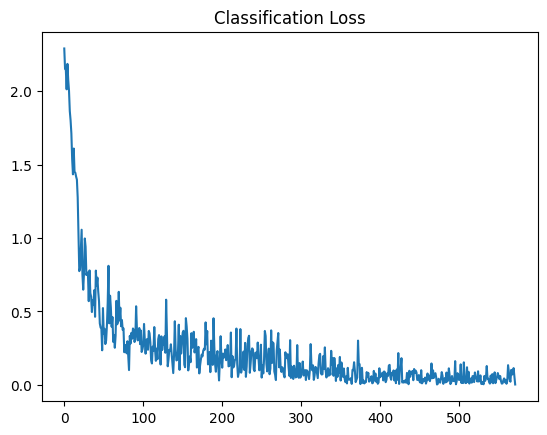

In [52]:
plt.title("Classification Loss")
plt.plot(range(len(ll_c)), ll_c)

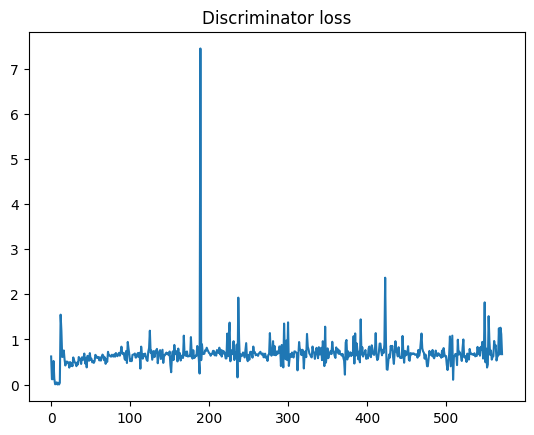

In [53]:
plt.title("Discriminator loss")
plt.plot(range(len(ll_d)), ll_d)

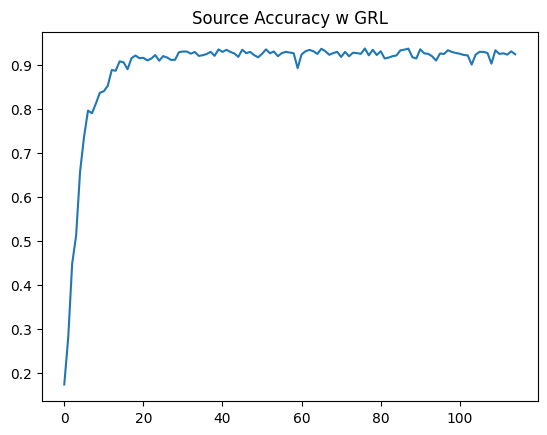

In [54]:
plt.title("Source Accuracy w GRL")
plt.plot(range(len(s_acc_lst)), s_acc_lst)

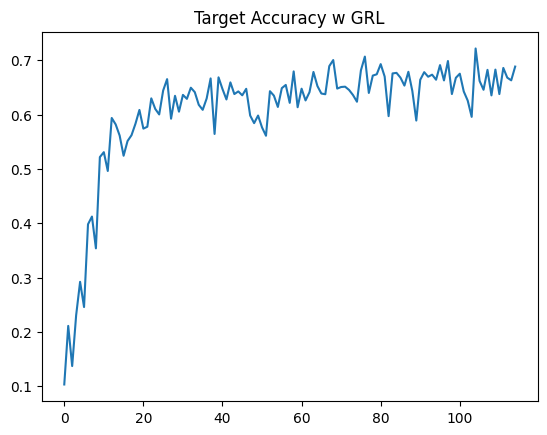

In [55]:
plt.title("Target Accuracy w GRL")
plt.plot(range(len(t_acc_lst)), t_acc_lst)

In [56]:
print("Maximum Source Accuracy w GRL:",max(s_acc_lst))
print("Maximum Target Accuracy w GRL:",max(t_acc_lst))

Maximum Source Accuracy w GRL: 0.9366548862937922
Maximum Target Accuracy w GRL: 0.7215


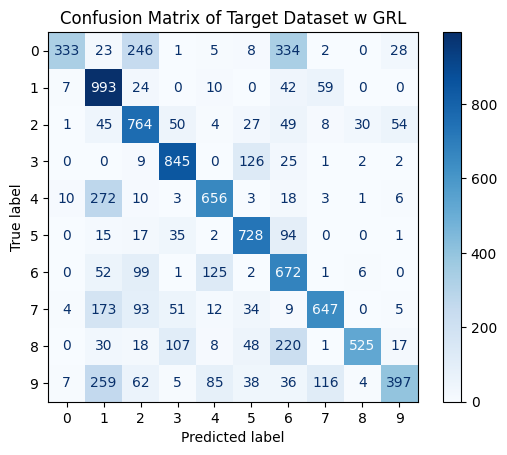

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

# Set models to evaluation mode
F.eval()
C.eval()

all_preds = []
all_labels = []

# Run on test data
with torch.no_grad():
    for data, labels in test_loader:  # Replace with your actual test DataLoader
        data, labels = data.to(DEVICE), labels.to(DEVICE)

        # Forward pass through feature extractor and classifier
        features = F(data)
        outputs = C(features)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Display the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix of Target Dataset w GRL")
plt.show()